# Creating Customer Segments

**Project Status: In Progress (Updated: 3/14/2016)

This project will analyze a dataset containing annual spending amounts for internal structure, to understand the variation in the different types of customers that a wholesale distributor interacts with.

In [135]:
# Import libraries: NumPy, pandas, matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
import seaborn as sns

%matplotlib inline

In [136]:
# Read dataset
data = pd.read_csv("wholesale-customers.csv")
print "Dataset has {} rows, {} columns".format(*data.shape)


Dataset has 440 rows, 6 columns


In [195]:
data

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
0,12669,9656,7561,214,2674,1338
1,7057,9810,9568,1762,3293,1776
2,6353,8808,7684,2405,3516,7844
3,13265,1196,4221,6404,507,1788
4,22615,5410,7198,3915,1777,5185
5,9413,8259,5126,666,1795,1451
6,12126,3199,6975,480,3140,545
7,7579,4956,9426,1669,3321,2566
8,5963,3648,6192,425,1716,750
9,6006,11093,18881,1159,7425,2098


In [138]:
data.describe()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


In [139]:
data.corr()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
Fresh,1.000000,0.100510,-0.011854,0.345881,-0.101953,0.244690
Milk,0.100510,1.000000,0.728335,0.123994,0.661816,0.406368
Grocery,-0.011854,0.728335,1.000000,-0.040193,0.924641,0.205497
Frozen,0.345881,0.123994,-0.040193,1.000000,-0.131525,0.390947
Detergents_Paper,-0.101953,0.661816,0.924641,-0.131525,1.000000,0.069291
Delicatessen,0.244690,0.406368,0.205497,0.390947,0.069291,1.000000


##Feature Transformation

**1)** In this section you will be using PCA and ICA to start to understand the structure of the data. Before doing any computations, what do you think will show up in your computations? List one or two ideas for what might show up as the first PCA dimensions, or what type of vectors will show up as ICA dimensions.

Answer:

###PCA

Principal Component Analysis:
       Fresh      Milk   Grocery    Frozen  Detergents_Paper  Delicatessen
PC                                                                        
1  -0.976537 -0.121184 -0.061540 -0.152365          0.007054     -0.068105
2  -0.110614  0.515802  0.764606 -0.018723          0.365351      0.057079
3  -0.178557  0.509887 -0.275781  0.714200         -0.204410      0.283217
4  -0.041876 -0.645640  0.375460  0.646292          0.149380     -0.020396
5   0.015986  0.203236 -0.160292  0.220186          0.207930     -0.917077

Explained Variance of Each Component:
PC
1    0.459614
2    0.405172
3    0.070030
4    0.044023
5    0.015022
dtype: float64


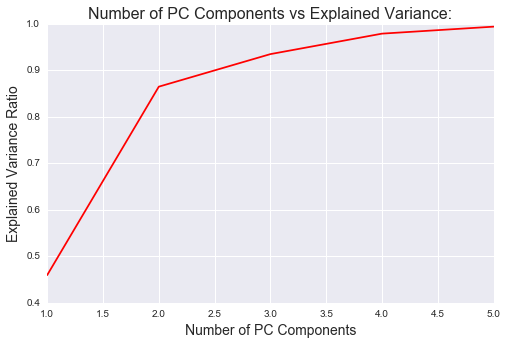

In [220]:
# TODO: Apply PCA with the same number of dimensions as variables in the dataset
def doPCA():
    from sklearn.decomposition import PCA
    pca = PCA(n_components=5)
    pca.fit(data)
    return pca

# Print the components and the amount of variance in the data contained in each dimension
pca = doPCA()
df = pd.DataFrame(pca.components_, columns =(data.columns), index=['1', '2', '3', '4','5'])
df.index.names = ['PC']
print "Principal Component Analysis:"
print df

ex_var = pca.explained_variance_ratio_
df_var = pd.Series(ex_var,index=['1','2','3','4','5'])
df_var.index.names = ['PC']
print "\nExplained Variance of Each Component:"
print df_var

pl.figure(figsize=(8,5))
x = np.arange(1,6)
y = np.cumsum(ex_var)
pl.plot(x,y,color = "r")
pl.xlabel("Number of PC Components", fontsize = 14)
pl.ylabel("Explained Variance Ratio", fontsize =14)
pl.title("Number of PC Components vs Explained Variance:", fontsize = 16)
pl.show()


First PC: [-0.97653685 -0.12118407 -0.06154039 -0.15236462  0.00705417 -0.06810471]
Second PC: [-0.11061386  0.51580216  0.76460638 -0.01872345  0.36535076  0.05707921]


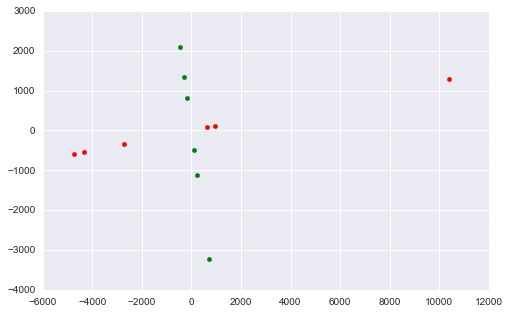

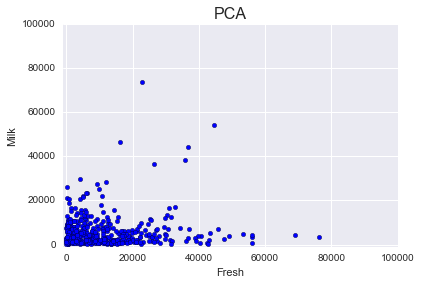

In [219]:
first_pc = pca.components_[0]
second_pc = pca.components_[1]
print "First PC:", first_pc
print "Second PC:", second_pc

transformed_data = pca.transform(data)
pl.figure(figsize =(8,5))
for ii, jj in zip(transformed_data, data):
    pl.scatter(first_pc[0]*ii[0], first_pc[1]*ii[0],color="r")
    pl.scatter(second_pc[0]*ii[1], second_pc[1]*ii[1],color = "g")
data.plot.scatter(x = 'Fresh', y = 'Milk', xlim = [-1000,100000], ylim = [-1000,100000], color = "b")
pl.title("PCA", fontsize = 16)
pl.show()



**2)** How quickly does the variance drop off by dimension? If you were to use PCA on this dataset, how many dimensions would you choose for your analysis? Why?

Answer: 

**3)** What do the dimensions seem to represent? How can you use this information?

Answer: 

###ICA

In [ ]:
# TODO: Fit an ICA model to the data
# Note: Adjust the data to have center at the origin first!
from sklearn.decomposition import FastICA
ica = 

# Print the independent components
print ica.components_

**4)** For each vector in the ICA decomposition, write a sentence or two explaining what sort of object or property it corresponds to. What could these components be used for?

Answer: 

##Clustering

In this section you will choose either K Means clustering or Gaussian Mixed Models clustering, which implements expectation-maximization. Then you will sample elements from the clusters to understand their significance.

###Choose a Cluster Type

**5)** What are the advantages of using K Means clustering or Gaussian Mixture Models?

Answer: 

**6)** Below is some starter code to help you visualize some cluster data. The visualization is based on [this demo](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_digits.html) from the sklearn documentation.

In [ ]:
# Import clustering modules
from sklearn.cluster import KMeans
from sklearn.mixture import GMM

In [ ]:
# TODO: First we reduce the data to two dimensions using PCA to capture variation
reduced_data = 
print reduced_data[:10]  # print upto 10 elements

In [ ]:
# TODO: Implement your clustering algorithm here, and fit it to the reduced data for visualization
# The visualizer below assumes your clustering object is named 'clusters'

clusters = 
print clusters

In [ ]:
# Plot the decision boundary by building a mesh grid to populate a graph.
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
hx = (x_max-x_min)/1000.
hy = (y_max-y_min)/1000.
xx, yy = np.meshgrid(np.arange(x_min, x_max, hx), np.arange(y_min, y_max, hy))

# Obtain labels for each point in mesh. Use last trained model.
Z = clusters.predict(np.c_[xx.ravel(), yy.ravel()])

In [ ]:
# TODO: Find the centroids for KMeans or the cluster means for GMM 

centroids = 
print centroids

In [ ]:
# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.title('Clustering on the wholesale grocery dataset (PCA-reduced data)\n'
          'Centroids are marked with white cross')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

**7)** What are the central objects in each cluster? Describe them as customers.

Answer: 

###Conclusions

** 8)** Which of these techniques did you feel gave you the most insight into the data?

Answer: 

**9)** How would you use that technique to help the company design new experiments?

Answer: 

**10)** How would you use that data to help you predict future customer needs?

Answer: 